<a href="https://colab.research.google.com/github/zanuarts/dicoding-BPML/blob/master/dicoding_17_LastSubmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Cell Detection

In [ ]:
import os
os.environ['KAGGLE_USERNAME']= # Kaggle Username
os.environ['KAGGLE_KEY'] = # Kaggle Key

## Download and unzip the Dataset

In [ ]:
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria

100% 673M/675M [00:07<00:00, 114MB/s] 
100% 675M/675M [00:07<00:00, 88.7MB/s]


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator 

print(tf.__version__)

2.3.0


In [ ]:
import zipfile

local_zip = '/content/cell-images-for-detecting-malaria.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

## Split Dataset

In [ ]:
mypath = '/content/cell_images'

In [ ]:
file_name = []
tag = []
full_path = []
for path, subdirs, files in os.walk(mypath):
    for name in files:
        full_path.append(os.path.join(path, name)) 
        tag.append(path.split('/')[-1])        
        file_name.append(name)

In [ ]:
import pandas as pd

In [ ]:
df = pd.DataFrame({"path":full_path,'file_name':file_name,"tag":tag})
df.groupby(['tag']).size()

tag
Parasitized    27560
Uninfected     27560
dtype: int64

In [ ]:
df

,path,file_name,tag
0,/content/cell_images/Uninfected/C166P127ThinF_...,C166P127ThinF_IMG_20151117_194410_cell_61.png,Uninfected
1,/content/cell_images/Uninfected/C81P42ThinF_IM...,C81P42ThinF_IMG_20150817_115942_cell_84.png,Uninfected
2,/content/cell_images/Uninfected/C113P74ThinF_I...,C113P74ThinF_IMG_20150930_135904_cell_147.png,Uninfected
3,/content/cell_images/Uninfected/C59P20thinF_IM...,C59P20thinF_IMG_20150803_112733_cell_2.png,Uninfected
4,/content/cell_images/Uninfected/C81P42ThinF_IM...,C81P42ThinF_IMG_20150817_120351_cell_177.png,Uninfected
...,...,...,...
55115,/content/cell_images/Parasitized/C111P72ThinF_...,C111P72ThinF_IMG_20150930_112827_cell_176.png,Parasitized
55116,/content/cell_images/Parasitized/C154P115ThinF...,C154P115ThinF_IMG_20151115_141336_cell_234.png,Parasitized
55117,/content/cell_images/Parasitized/C183P144NThin...,C183P144NThinF_IMG_20151201_223758_cell_138.png,Parasitized
55118,/content/cell_images/Parasitized/C59P20thinF_I...,C59P20thinF_IMG_20150803_113051_cell_151.png,Parasitized


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X= df['path']
y= df['tag']

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.20, random_state=300)

In [ ]:
df_val = pd.DataFrame({'path':X_val
              ,'tag':y_val
             ,'set':'validation-set'})

df_tr = pd.DataFrame({'path':X_train
              ,'tag':y_train
             ,'set':'train-set'})

In [ ]:
print('train size', len(df_tr))
print('val size', len(df_val))

train size 44096
val size 11024


In [ ]:
df_all = df_tr.append([df_val]).reset_index(drop=1)\

print('===================================================== \n')
print(df_all.groupby(['set','tag']).size(),'\n')

print('===================================================== \n')

df_all.sample(4)


set             tag        
train-set       Parasitized    22053
                Uninfected     22043
validation-set  Parasitized     5507
                Uninfected      5517
dtype: int64 




,path,tag,set
983,/content/cell_images/Parasitized/C118P79ThinF_...,Parasitized,train-set
27934,/content/cell_images/cell_images/Parasitized/C...,Parasitized,train-set
45470,/content/cell_images/Uninfected/C50P11thinF_IM...,Uninfected,validation-set
925,/content/cell_images/Parasitized/C182P143NThin...,Parasitized,train-set


## Move the dataset

In [ ]:
# !rm -rf /tmp/dataset/

In [ ]:
import shutil
from tqdm.notebook import tqdm as tq

In [ ]:
datasource_path = "/content/cell_images/"
dataset_path = "/content/dataset"

In [ ]:
for index, row in tq(df_all.iterrows()):
    
    file_path = row['path']
    if os.path.exists(file_path) == False:
            file_path = os.path.join(datasource_path,row['tag'],row['image'].split('.')[0])            
    
    if os.path.exists(os.path.join(dataset_path,row['set'],row['tag'])) == False:
        os.makedirs(os.path.join(dataset_path,row['set'],row['tag']))

    destination_file_name = file_path.split('/')[-1]
    file_dest = os.path.join(dataset_path,row['set'],row['tag'],destination_file_name)
    
    if os.path.exists(file_dest) == False:
        shutil.copy2(file_path,file_dest)

## Image Augmentation

In [ ]:
base_dir = '/content/dataset/'
train_dir = os.path.join(base_dir,'train-set')
validation_dir = os.path.join(base_dir,'validation-set')

In [ ]:
os.listdir(train_dir)

['Uninfected', 'Parasitized']

In [ ]:
os.listdir(validation_dir)

['Uninfected', 'Parasitized']

In [ ]:
train_uninfected_dir = os.path.join(train_dir, 'Uninfected')
train_parasitized_dir = os.path.join(train_dir, 'Parasitized')
validation_uninfected_dir = os.path.join(validation_dir, 'Uninfected')
validation_parasitized_dir = os.path.join(validation_dir, 'Parasitized')

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
validation_datagen = ImageDataGenerator(
    rescale = 1./255
)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'binary'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size = (128,128),
    batch_size = 32,
    class_mode = 'binary'
)

Found 26440 images belonging to 2 classes.
Found 9905 images belonging to 2 classes.


## Build Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,2),

    tf.keras.layers.Conv2D(128,(3,3), activation = 'relu'),
    tf.keras.layers.MaxPool2D(2,2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 126, 126, 64)      1792      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 61, 61, 64)        36928     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 28, 28, 128)       73856     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 12, 12, 128)      

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92):
      print("\nAkurasi mencapai 92%, train data diberhentikan !")
      self.model.stop_training = True

callbacks = myCallback()

In [ ]:
model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['accuracy']
)

history = model.fit(
    train_generator,
    steps_per_epoch = 20,
    epochs = 25,
    validation_data = validation_generator,
    validation_steps = 3,
    verbose = 1,
    callbacks = [callbacks]
)

Epoch 1/25
20/20 [==============================] - 30s 2s/step - loss: 0.7167 - accuracy: 0.5109 - val_loss: 0.6862 - val_accuracy: 0.5625
Epoch 2/25
20/20 [==============================] - 30s 1s/step - loss: 0.6958 - accuracy: 0.4609 - val_loss: 0.6933 - val_accuracy: 0.4792
Epoch 3/25
20/20 [==============================] - 30s 1s/step - loss: 0.6920 - accuracy: 0.5281 - val_loss: 0.6910 - val_accuracy: 0.4896
Epoch 4/25
20/20 [==============================] - 30s 1s/step - loss: 0.6916 - accuracy: 0.5234 - val_loss: 0.6771 - val_accuracy: 0.5625
Epoch 5/25
20/20 [==============================] - 30s 1s/step - loss: 0.6939 - accuracy: 0.5016 - val_loss: 0.6901 - val_accuracy: 0.5000
Epoch 6/25
20/20 [==============================] - 30s 1s/step - loss: 0.6783 - accuracy: 0.5797 - val_loss: 0.6396 - val_accuracy: 0.6979
Epoch 7/25
20/20 [==============================] - 30s 1s/step - loss: 0.6926 - accuracy: 0.5359 - val_loss: 0.6814 - val_accuracy: 0.6250
Epoch 8/25
20/20 [==

## Plot loss and Accuracy

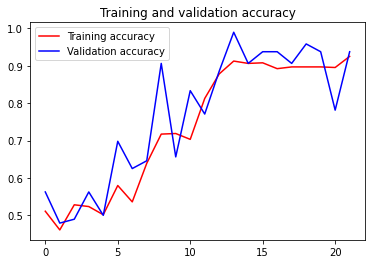

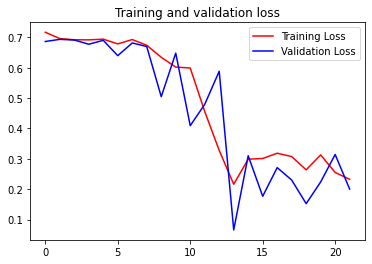

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Model TF-Lite

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/tmpy_g18cin/assets


In [ ]:
with tf.io.gfile.GFile('model.tflite', 'wb') as f:
    f.write(tflite_model)